# Granvik et al. (2018) NEO Model

In this second-last NEO tutorial we will take a look at a so-called NEO population model. This model, by Granvik et al (2018), is a numerically generated model with the aim to create an un-biased population of Near-Earth Objects (NEOs). We will download and parse the data automatically and later we'll take a look at how one can create kernel density estimator (KDE) based sky maps!

The details of the paper and model generation are beyond our scope. Take a direct look at their paper [here](https://www.sciencedirect.com/science/article/pii/S0019103517307017).

Before we dive in, let's download the data first:

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import re
import requests
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [2]:
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

In [3]:
# Define the directory and name of the Granvik data. The data are originally stored as a gzip
# file and need to be unzipped
data_dir = pathlib.Path("raw_data/")
data_dir.mkdir(parents=True, exist_ok=True)
granvik_neo_model_file_zip = pathlib.Path("Granvik+_2018_Icarus.dat.gz")
granvik_neo_model_file = pathlib.Path("Granvik+_2018_Icarus.dat")

data_filepath = data_dir / granvik_neo_model_file
download_filepath = data_dir / granvik_neo_model_file_zip
print(f"Our Granvik et al. (2018) file path: {data_filepath}")

Our Granvik et al. (2018) file path: raw_data/Granvik+_2018_Icarus.dat


In [4]:
# Download the Granvik Model
dl_link = "https://www.mv.helsinki.fi" \
          "/home/mgranvik/data/Granvik+_2018_Icarus/Granvik+_2018_Icarus.dat.gz"
response = requests.get(dl_link)
download_file_path = pathlib.Path(download_filepath)
with download_file_path.open(mode="wb+") as file_obj:
    file_obj.write(response.content)

In [5]:
# We use the standard libraries gzip and shutil to unzip the file
import gzip
import shutil

with gzip.open(download_file_path, 'rb') as f_in:
    with open(data_filepath, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Parsing the Model

Now we can open the model and load it into a Pandas dataframe. Additionally, we need to parse the orbital elements into a format that can later be used by SPICE.

In [6]:
granvik_model_df = pd.read_csv(data_filepath, names=["SemiMajorAxis_AU",
                                                     "Ecc_",
                                                     "Incl_deg",
                                                     "LongAscNode_deg",
                                                     "ArgP_deg",
                                                     "MeanAnom_deg",
                                                     "H"],
                               delim_whitespace=True)

*The dataframe structure has been derived from the corresponding README file of the [repository](https://www.mv.helsinki.fi/home/mgranvik/data/Granvik+_2018_Icarus/Granvik+_2018_Icarus.readme)*:

Version 1.0

File Granvik+_2018_Icarus.dat contains a realization of the NEO model
described in

Granvik, Morbidelli, Jedicke, Bolin, Bottke, Beshore, Vokrouhlicky,
Nesvorny, and Michel (2018). Debiased orbit and absolute-magnitude
distributions for near-Earth objects. Accepted for publication in
Icarus.

The file Granvik+_2018_Icarus.dat contains 802,000 synthetic NEOs with
17<H<25 parameterized by their orbits and absolute magnitudes. The 7
columns in the file are

1) semimajor axis [au]
2) eccentricity
3) inclination [deg]
4) longitude of ascending node [deg]
5) argument of perihelion [deg]
6) mean anomaly [deg]
7) absolute magnitude

Please cite the above article if you use the data in your
publications.

Mikael Granvik
27-04-2018

In [7]:
granvik_model_df

,SemiMajorAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,H
0,2.574981,0.783617,33.520763,278.480591,75.952057,103.833748,21.064367
1,1.682046,0.275324,25.924536,169.683060,350.926636,46.401562,24.683197
2,2.480214,0.546448,14.240792,121.685623,316.509247,279.612305,24.843449
3,1.941440,0.620780,13.679822,8.245143,175.087372,129.364609,24.954794
4,1.114843,0.548071,37.906609,209.261627,37.110592,120.817390,24.342936
...,...,...,...,...,...,...,...
801995,2.877656,0.607120,6.684607,118.446182,39.764286,265.229523,23.330488
801996,1.563997,0.207188,28.263660,135.846954,82.046822,101.014885,24.990154
801997,2.679385,0.535874,7.462100,227.803268,272.786926,153.444550,23.996401
801998,1.592931,0.826241,43.307148,337.204224,43.215237,107.381775,24.795914


## Enrich the dataframe

We need to convert some parameters and derive other orbital elements for SPICE:

In [8]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [9]:
# Add the perihelion and convert the angular values to deg
granvik_model_df.loc[:, "Perihelion_AU"] = (1.0 - granvik_model_df["Ecc_"]) \
                                               * granvik_model_df["SemiMajorAxis_AU"]

granvik_model_df.loc[:, "Incl_rad"] = np.radians(granvik_model_df["Incl_deg"])
granvik_model_df.loc[:, "LongAscNode_rad"] = np.radians(granvik_model_df["LongAscNode_deg"])
granvik_model_df.loc[:, "ArgP_rad"] = np.radians(granvik_model_df["ArgP_deg"])

# Convert AU to km
granvik_model_df.loc[:, "Perihelion_km"] = \
    granvik_model_df["Perihelion_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))
granvik_model_df.loc[:, "SemiMajorAxis_km"] = \
    granvik_model_df["SemiMajorAxis_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))

## Generate "generic" positions

To compute a time-invariant, normalized distribution on NEOs in the sky, we need to populate all orbits with (theoretically), an infinite number of objects. Then we can compute their corresponding brightness (apparent magnitude) and consequently their observability along their orbit. However, theoretically, we also need to move Earth along its orbit too and normalize a large number of these brightness distributions.

However, we simplify a few things. Feel free though, to extend this project :)!

*So are we going to do?*

- Of course we cannot create a infinite number of NEOs. Thus, we populate each orbit with 36 NEOs in an angular distance of 10 degrees. On a circular orbit, this makes sense ... but how does it look like on an elliptical orbit? The Mean Anomaly does not correspond to some kind of "actual" position of the NEO, but is a projection on a theoretical, circular construct (take a look at Wikipedia: https://en.wikipedia.org/wiki/Mean_anomaly). But there is also something called true anomaly. Like the "actual" position of the NEO. Which one shall we take? Let's take a look now. What we need: a positional parameter that somehow considers the "dwell time" of an object (e.g., an object at the Perihelion has a shorter dwell time than far away at the Aphelion)

- Additionally, we do not want to exceed computational time. So let's put our home planet on a certain position (we do not integrate over its entire orbit). Feel free though to extend this model in this regard!

### Sample Orbit

Let's take a look at some kind of sample orbit

In [10]:
# First, we need to define a function that converts true anomaly values to mean anomalies (since
# SPICE does not handle true anomalies
def true2mean(true_anom, ecc):
    
    atan2_x1 = -1.0 * np.sqrt(1.0 - ecc**2.0) * np.sin(true_anom)
    atan2_x2 = -1.0 * ecc - np.cos(true_anom)
    
    mean_anom = np.arctan2(atan2_x1, atan2_x2) \
                + np.pi \
                - ecc * ((np.sqrt(1.0 - ecc**2.0) * np.sin(true_anom)) 
                         / (1.0 + ecc * np.cos(true_anom)))
    
    return mean_anom

In [11]:
# Let's create an example plot with the true anomaly distribution
# Sample orbit:
sample_rp = spiceypy.convrt(0.5, "AU", "km")
sample_ecc = 0.7
sample_incl = 0.0
sample_lnode = 0.0
sample_argp = 0.0
sample_et = spiceypy.utc2et("2000-001T12:00:00")

In [12]:
# First we create a "complete" orbit that is used to explain our method:
mean_anomaly = np.radians(np.arange(0, 360, 0.1))

# List that will store the positions in 2D (X-Y plane)
sample_trajectory = []

for k in tqdm.tqdm(mean_anomaly):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    sample_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                              spiceypy.convrt(temp_state[1], "km", "AU")])
    
sample_trajectory = np.array(sample_trajectory)

100%|████████████████████████████████████| 3600/3600 [00:00<00:00, 57773.00it/s]


In [13]:
# Now we create 36 NEO positions using the mean anomaly. Basically ... we need the same code again!
mean_anomaly = np.radians(np.arange(0, 360, 10))

# List that will store the positions in 2D (X-Y plane)
mean_anom_10deg_trajectory = []

for k in tqdm.tqdm(mean_anomaly):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    mean_anom_10deg_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                                       spiceypy.convrt(temp_state[1], "km", "AU")])
    
mean_anom_10deg_trajectory = np.array(mean_anom_10deg_trajectory)

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 26905.73it/s]


In [14]:
# And finally a list with the true anomaly values!
# Now we create 36 NEO positions using the mean anomaly. Basically ... we need the same code again!
true_anomaly = np.radians(np.arange(0, 360, 10))
mean_from_true_anom = [true2mean(n, sample_ecc) for n in true_anomaly]

# List that will store the positions in 2D (X-Y plane)
true_anom_10deg_trajectory = []

for k in tqdm.tqdm(mean_from_true_anom):

    # Compute the state vector and store in positional values in X-Y direction, converted in AU
    temp_state = spiceypy.conics([sample_rp, sample_ecc, sample_incl, sample_lnode, sample_argp,
                                  k, sample_et, gm_sun], sample_et)
    true_anom_10deg_trajectory.append([spiceypy.convrt(temp_state[0], "km", "AU"),
                                       spiceypy.convrt(temp_state[1], "km", "AU")])
    
true_anom_10deg_trajectory = np.array(true_anom_10deg_trajectory)

100%|████████████████████████████████████████| 36/36 [00:00<00:00, 22641.32it/s]


Text(0.125, 0.5, 'Eclip. y in AU')

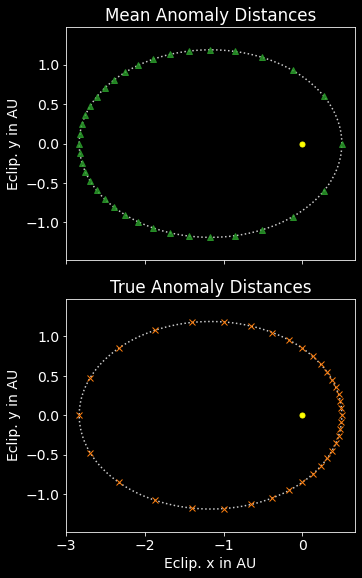

In [15]:
# We plot now the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

ax1.set_title("Mean Anomaly Distances")
ax1.scatter(0, 0, color="yellow", s=25)
ax1.plot(sample_trajectory[:, 0],
        sample_trajectory[:, 1],
        alpha=0.8,
        color="white",
        linestyle="dotted")
ax1.plot(mean_anom_10deg_trajectory[:, 0],
        mean_anom_10deg_trajectory[:, 1],
        alpha=0.8,
        color="tab:green",
        linestyle="None",
        marker="^")
ax1.axis('equal')

ax2.set_title("True Anomaly Distances")
ax2.scatter(0, 0, color="yellow", s=25)
ax2.plot(sample_trajectory[:, 0],
        sample_trajectory[:, 1],
        alpha=0.8,
        color="white",
        linestyle="dotted")
ax2.plot(true_anom_10deg_trajectory[:, 0],
        true_anom_10deg_trajectory[:, 1],
        alpha=1,
        color="tab:orange",
        linestyle="None",
        marker="x")
ax2.axis('equal')

plt.tight_layout()

ax2.set_xlabel("Eclip. x in AU")
ax1.set_ylabel("Eclip. y in AU")
ax2.set_ylabel("Eclip. y in AU")

Long story short: we take the mean anomaly to "enrich" our orbits!

### Creating more NEOs

So let's take our dataframe and drop the Mean Anomaly column. We replace it with an array of meananomalies (in 10 degree steps) and "explode" the dataframe:

In [16]:
# First, let's add an epoch:
granvik_model_df.loc[:, "epoch_et"] = spiceypy.utc2et("2000-001T12:00:00")

In [17]:
# We remove the Mean Anomaly first and ...
granvik_model_df.drop(columns="MeanAnom_deg", inplace=True)

# ... replace it with an array
mean_anomaly_deg_array = np.arange(0, 360, 60)
granvik_model_df.loc[:, "MeanAnom_deg"] = [mean_anomaly_deg_array for i in granvik_model_df.index]

In [18]:
# Explode the list
granvik_model_df = granvik_model_df.explode("MeanAnom_deg").copy()
granvik_model_df.loc[:, "MeanAnom_rad"] = \
    granvik_model_df["MeanAnom_deg"].apply(lambda x: np.radians(x))
granvik_model_df.reset_index(drop=True, inplace=True)

In [19]:
granvik_model_df

,SemiMajorAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,H,Perihelion_AU,Incl_rad,LongAscNode_rad,ArgP_rad,Perihelion_km,SemiMajorAxis_km,epoch_et,MeanAnom_deg,MeanAnom_rad
0,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,0,0.000000
1,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,60,1.047198
2,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,120,2.094395
3,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,180,3.141593
4,2.574981,0.783617,33.520763,278.480591,75.952057,21.064367,0.557182,0.585048,4.860403,1.325613,8.335328e+07,3.852117e+08,64.183927,240,4.188790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811995,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,60,1.047198
4811996,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,120,2.094395
4811997,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,180,3.141593
4811998,2.591117,0.826896,22.001493,334.001678,286.224030,24.542505,0.448532,0.383999,5.829429,4.995552,6.709938e+07,3.876256e+08,64.183927,240,4.188790


In [20]:
# Store the resulting dataframe
data_dir = pathlib.Path("results_data/Granvik")
data_dir.mkdir(parents=True, exist_ok=True)
dataframe_filepath = data_dir / "enriched_granvik_model.parquet"

In [21]:
# Save
granvik_model_df.to_parquet(dataframe_filepath)

## Next steps

We have all building blocks now to create "normalized" detection sky maps. We need to compute the positions of the NEOs and their corresponding brightness. Then, wel'll apply the KDE method to get a probability density function!